In [1]:
#imports
import torch
from torch import nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import json
import glob
import time
from PIL import Image

In [2]:
from transformers import CLIPProcessor, CLIPModel

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

preprocess = processor.feature_extractor
tokenizer = processor.tokenizer

c:\python\lib\site-packages\transformers\models\clip\processing_clip.py:142: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [3]:
from transformers import CLIPProcessor, CLIPModel

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

preprocess = processor.feature_extractor
tokenizer = processor.tokenizer

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [3]:
checkpoint = torch.load("Models/model_clip-vit-large-patch14/model.pt", map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [2]:
from transformers import CLIPProcessor, CLIPModel

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14-336").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14-336")

preprocess = processor.feature_extractor
tokenizer = processor.tokenizer

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
c:\python\lib\site-packages\transformers\models\clip\processing_clip.py:142: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [3]:
class MLM(nn.Module):
    def __init__(self, dense_size, vocab_size):
        super().__init__()
        self.linear = nn.Linear(dense_size, vocab_size)
        
    def forward(self, dense_vec):
        term_importances = torch.log1p(torch.relu(self.linear(dense_vec)))
        return term_importances

In [47]:
#before training
rec1,rec5,rec10 = test_sparse_performance(text_encoder, image_encoder, test_images, test_features)

print(rec1)
print(rec5)
print(rec10)

5000
4500 , time since last:  0.50863718986511234
tensor(0.5214)
tensor(0.8196)
tensor(0.9000)


In [46]:
def test_sparse_performance(text_model, image_model, test_ims, test_cap):
    with torch.no_grad():
        x, _ = test_ims.shape
        encoded_ims = torch.empty(int(x), 49408).to(device)
        for i in range(0, len(test_ims), 64):
            encoded_ims[i:i+64] = image_model(test_ims[i:i+64])


        encoded_caps = torch.empty(int(x*5), 49408)
        for i in range(0, len(encoded_caps), 64):
            encoded_caps[i:i+64] = text_model(test_cap[i:i+64])
            
        
        encoded_ims = encoded_ims / encoded_ims.norm(dim=-1, keepdim=True)
        encoded_caps = encoded_caps / encoded_caps.norm(dim=-1, keepdim=True)

        recall_1, recall_5, recall_10 = [],[],[]
        i = 0
        j = 0
        image_id = 0
        print(len(encoded_caps))
        t = time.time()
        for text_feature in encoded_caps:
            if (j%500) == 0:
                print(j, ", time since last: ", time.time() - t, end='\r')
                t = time.time()
            similarity = (100.0 * text_feature.to(device) @ encoded_ims.T).softmax(dim=-1)
            _, indices = similarity.topk(10)
            
            recall_1.append(image_id in indices[0])
            recall_5.append(image_id in indices[:5])
            recall_10.append(image_id in indices)

            i += 1
            j += 1
            if i == 5:
                i = 0
                image_id += 1

        print("")
        return torch.Tensor(recall_1).mean(), torch.Tensor(recall_5).mean(), torch.Tensor(recall_10).mean()       

In [5]:
class TrainBatches():
    def __init__(self, image_vectors, captions):

        self.images = image_vectors
        self.captions  = captions

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        image = self.images[idx]
        caption = self.captions[idx]
        return image,caption

In [6]:
#open the json file for annotations
f = open('datasets/flickr30k/dataset_flickr30k.json')
data = json.load(f)

# load all captions
caps = [x['sentences'] for x in data['images'] if x.get('split') == 'train']
test_caps = [x['sentences'] for x in data['images'] if x.get('split') == 'test']

files = []
test_files = []
for x in data['images']:
    if x.get('split') == 'train':
        files.append('datasets/flickr30k/train/' + x['filename'])
    
    elif x.get('split') == 'test':
        test_files.append('datasets/flickr30k/test/' + x['filename'])
            
captions = []
for x in caps:
    for y in x:
        captions.append(y)
        
test_captions = []
for x in test_caps:
    for y in x:
        test_captions.append(y)
    
captions = [x.get('raw') for x in captions]
test_captions = [x.get('raw') for x in test_captions]

# these captions are too long and need adjusting
captions[13035] = 'Four young adults sit outside on a wooden deck near a building around a small round table, while another person stands on the edge of the deck, leaning on the wooden railing, with the sun shining on one of them, one holding a cellphone out in front of himself and another holding a green and red soda can.'
captions[14580] = 'A man wearing a helmet, red pants with white and a white and red shirt is on a small bicycle using only his hands, while another man wearing a light blue shirt with dark blue trim and black pants with red stripes is standing nearby, gesturing toward the first man and holding a small figurine.'
captions[120165] = 'In this photo there is a man in a dirty white shirt and a black hat with yellow stained teeth, he looks happy and it appears that he is also repairing something.'
test_captions[3905] = 'Two boys are looking upwards with their arms streteched to the sky, the boy on the left is wearing a blue vest jacket with a gray shirt, black jogging pants and a hat, and the boy on the right is wearing a silver vest jacket, with blue long-sleeved undershirt, gray pants, black tennis shoes and has black short hair and glasses.'

In [7]:
files = files[0:10]
captions = captions[0:50]

test_files = test_files[0:10]
test_captions = test_captions[0:50]

In [7]:
# encode images
L = len(files)
batch_size = 64
t1 = time.time()
with torch.no_grad():
    encoded_ims = torch.Tensor()
    for i in range(0, L, batch_size):
        print(i,"/",L, end='\r')
        images = torch.Tensor().to(device)
        for x in range(batch_size):
            if (i + x) < L:
                image = preprocess(Image.open(files[i+x]), return_tensors='pt')['pixel_values'].to(device)
                images = torch.cat((images, image), 0)
                
        ims = model.vision_model(images).pooler_output
        ims = model.visual_projection(ims)
        encoded_ims = torch.cat((encoded_ims, ims.to("cpu")), 0)

p = 0
encoded_images = torch.Tensor().to(device)
for image in encoded_ims:
    if (p%100) == 0:
        print(p,"/",L, end='\r')
        
    encoded_images = torch.cat((encoded_images, image.to(device).repeat(5,1)), 0)
    p += 1
    
print("")
print("done")
print(time.time() - t1)

28900 / 29000 / 29000 / 29000 / 29000 / 29000 / 29000 / 29000 / 29000 / 29000 / 29000 / 29000 / 29000 / 29000
done
293.0039150714874


In [ ]:
# vitb32, vitL14@336, vitL14

In [7]:
encoded_images = torch.load("pt datafiles/flickr/MLP/encoded_images_vitb32.pt")

In [8]:
encoded_images.shape

torch.Size([145000, 512])

In [ ]:
torch.save(encoded_images, "encoded_images_vitb32.pt")

In [ ]:
# encode captions
L = len(captions)
batch_size = 128
t1 = time.time()
with torch.no_grad():
    text_features = torch.Tensor().to(device)
    for i in range(0, L, batch_size):
        print(i,"/",L, end='\r')
        text = tokenizer(captions[i:i+batch_size], padding=True, return_tensors='pt').to(device)
        
        text_output = model.text_model(**text).pooler_output
        text_output = model.text_projection(text_output)      
        text_features = torch.cat((text_features, text_output), 0)
        
print("")
print("done")
print(time.time() - t1)

In [9]:
text_features = torch.load("pt datafiles/flickr/MLP/encoded_captions_vitb32.pt")

In [10]:
print(torch.cuda.memory_allocated())

1201075200


In [11]:
torch.save(text_features, "encoded_captions_vitL14@336.pt")

In [9]:
# encode images
L = len(test_files)
batch_size = 128
t1 = time.time()
with torch.no_grad():
    test_ims = torch.Tensor()
    for i in range(0, L, batch_size):
        print(i,"/",L, torch.cuda.memory_allocated(), end='\r')
        images = torch.Tensor().to(device)
        for x in range(batch_size):
            if (i + x) < L:
                image = preprocess(Image.open(test_files[i+x]), return_tensors='pt')['pixel_values'].to(device)
                images = torch.cat((images, image), 0)
                
        ims = model.vision_model(images).pooler_output
        ims = model.visual_projection(ims)
        test_ims = torch.cat((test_ims, ims.to("cpu")), 0)

test_images = test_ims.to(device)
print("")
print("done")
print(time.time() - t1)

992 / 1000
done


In [11]:
test_images = torch.load("pt datafiles/flickr/MLP/test_images_vitb32.pt")

In [12]:
print(torch.cuda.memory_allocated())

1203172352


In [ ]:
torch.save(test_images, "test_images_vitL14@336.pt")

In [13]:
# encode test captions
L = len(test_captions)
batch_size = 128
with torch.no_grad():
    test_features = torch.Tensor().to(device)
    for i in range(0, L, batch_size):
        print(i,"/",L, end='\r')
        text = tokenizer(test_captions[i:i+batch_size], padding=True, return_tensors='pt').to(device)
        
        text_output = model.text_model(**text).pooler_output
        text_output = model.text_projection(text_output)      
        test_features = torch.cat((test_features, text_output), 0)
        
print("")
print("done")

4992 / 5000/ 5000 / 5000 / 5000
done


In [13]:
test_features = torch.load("pt datafiles/flickr/MLP/test_captions_vitb32.pt")

In [15]:
torch.save(test_features, "test_captions_vitL14@336.pt")

In [14]:
batchsize = 64

dataset = TrainBatches(encoded_images, text_features)
train_dataloader = DataLoader(dataset, batch_size = batchsize, shuffle=True)

In [15]:
dense_text_size = model.text_projection.weight.shape[0]
dense_image_size = model.visual_projection.weight.shape[0]
vocab_size = model.text_model.config.vocab_size

text_encoder = MLM(dense_text_size, vocab_size).to(device)
image_encoder = MLM(dense_image_size, vocab_size).to(device)

In [16]:
im_checkpoint = torch.load("Models/8.pt", map_location='cpu')

image_encoder = MLM(dense_image_size, vocab_size).to(device)
image_encoder.load_state_dict(im_checkpoint['model_state_dict'])

<All keys matched successfully>

In [43]:
#before training
rec1,rec5,rec10 = test_sparse_performance(text_encoder, image_encoder, test_images, test_features)

print(rec1)
print(rec5)
print(rec10)

5000
4500 , time since last:  0.47563505172729496
tensor(0.5214)
tensor(0.8196)
tensor(0.9000)


epoch: 0 batch: 2250 / 2265
loss: 1988.5013686418533
testing recall scores..
5000
4500 , time since last:  0.48062872886657715
R@1: tensor(0.4114)
epoch done

epoch: 1 batch: 2250 / 2265
loss: 976.5060137659311
testing recall scores..
5000
4500 , time since last:  0.48062896728515625
R@1: tensor(0.4604)
epoch done

epoch: 2 batch: 2250 / 2265
loss: 878.0527661889791
testing recall scores..
5000
4500 , time since last:  0.51563835144042975
R@1: tensor(0.4744)
epoch done

epoch: 3 batch: 2250 / 2265
loss: 843.093530267477
testing recall scores..
5000
4500 , time since last:  0.5016362667083748
R@1: tensor(0.4750)
epoch done

epoch: 4 batch: 2250 / 2265
loss: 823.2822391688824
testing recall scores..
5000
4500 , time since last:  0.48563003540039066
R@1: tensor(0.4858)
epoch done

epoch: 5 batch: 2250 / 2265
loss: 788.8231510519981
testing recall scores..
5000
4500 , time since last:  0.47916412353515625
R@1: tensor(0.4862)
epoch done

epoch: 6 batch: 2250 / 2265
loss: 781.4137491136789
t

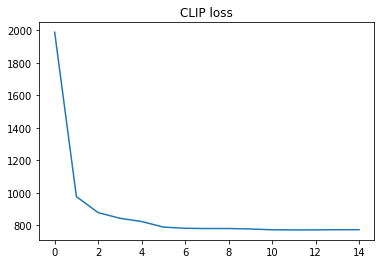

In [18]:
loss_img = torch.nn.CrossEntropyLoss()
loss_txt = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(text_encoder.parameters(), lr=1e-4,betas=(0.9,0.98),eps=1e-6,weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10], gamma=0.1)

vocab_size = model.text_model.config.vocab_size
epochs = 15
totalbatches = int(len(dataset) / batchsize)
losses=[]
test_loss=[[rec1],[rec5],[rec10]]
for epoch in range(0, epochs):
    i = 0
    batch_loss = 0
    for batch in train_dataloader:
        if i % 25 == 0:
            print("epoch:", epoch, "batch:", i, "/", totalbatches, end='\r')
       
        optimizer.zero_grad()
        dense_images, dense_caps = batch
        
        # sparse encoding
        with torch.no_grad():
            sparse_ims = image_encoder(dense_images)
            
        sparse_caps = text_encoder(dense_caps)

        # determine logits
        logits_per_image = sparse_ims @ sparse_caps.t()
        logits_per_text = logits_per_image.t()
        
        # compute losses
        ground_truth = torch.arange(len(dense_images),dtype=torch.long,device=device)
        
        loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
            
        batch_loss += loss.item()
        loss.backward()
        
        optimizer.step()
        i+=1
        
    scheduler.step()
    losses.append(batch_loss)
    print("")
    print("loss:", batch_loss)
    
    print("testing recall scores..")
    recall1,recall5,recall10 = test_sparse_performance(text_encoder, image_encoder, test_images, test_features)
    test_loss[0].append(recall1)
    test_loss[1].append(recall5)
    test_loss[2].append(recall10)
    print("R@1:", recall1)
    print("epoch done")
    print("")
"""
    torch.save({
        'epoch':epoch,
        'model_state_dict': sparse_mlm.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss,
        }, f"Models/" + str(epoch) + ".pt")
"""      
print("")
print("done")

plt.plot(losses)
plt.title('CLIP loss')
plt.show()

In [19]:
test_loss

[[tensor(0.0006),
  tensor(0.4114),
  tensor(0.4604),
  tensor(0.4744),
  tensor(0.4750),
  tensor(0.4858),
  tensor(0.4862),
  tensor(0.4862),
  tensor(0.4892),
  tensor(0.4878),
  tensor(0.4888),
  tensor(0.4894),
  tensor(0.4890),
  tensor(0.4890),
  tensor(0.4898),
  tensor(0.4894)],
 [tensor(0.0048),
  tensor(0.6038),
  tensor(0.6454),
  tensor(0.6594),
  tensor(0.6572),
  tensor(0.6690),
  tensor(0.6670),
  tensor(0.6668),
  tensor(0.6702),
  tensor(0.6710),
  tensor(0.6712),
  tensor(0.6704),
  tensor(0.6704),
  tensor(0.6706),
  tensor(0.6704),
  tensor(0.6700)],
 [tensor(0.0098),
  tensor(0.6140),
  tensor(0.6540),
  tensor(0.6676),
  tensor(0.6660),
  tensor(0.6776),
  tensor(0.6752),
  tensor(0.6752),
  tensor(0.6790),
  tensor(0.6802),
  tensor(0.6790),
  tensor(0.6780),
  tensor(0.6778),
  tensor(0.6782),
  tensor(0.6780),
  tensor(0.6776)]]

In [28]:
with torch.no_grad():
    total_nonzero = 0
    i = 0
    for feature in text_features:
        sparse = text_encoder(feature)
        total_nonzero += (len(sparse) - torch.count_nonzero(sparse))/len(sparse)
        i += 1
        if (i%10000) == 0:
            print(i)
        
    print(total_nonzero/i)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
tensor(0.3365, device='cuda:0')


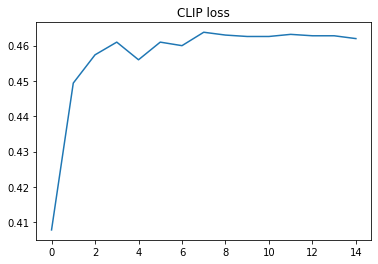

In [20]:
plt.plot(test_loss[0][1:])
plt.title('CLIP loss')
plt.show()

In [20]:
#open the json file for annotations
f = open("C:/Users/Lalashops/Desktop/MasterThesis/random images/vocab.json", encoding = 'utf-8')
vocab = json.load(f)

In [34]:
sparse_encoding_cap = text_encoder(text_features[0])

In [24]:
captions[0]

'Two young guys with shaggy hair look at their hands while hanging out in the yard.'

In [31]:
sparse_encoding_im = image_encoder(encoded_images[0])

In [21]:
sparse_encoding = image_encoder(test_images[0])

In [41]:
l = torch.topk(sparse_encoding_im, 100).indices
for idx in torch.topk(sparse_encoding_cap, 20).indices:
    print(idx in l)

True
True
True
True
True
False
True
True
False
False
False
True
False
False
False
True
False
False
False
False


In [37]:
torch.topk(sparse_encoding_im, 100)

torch.return_types.topk(
values=tensor([0.8103, 0.7990, 0.7422, 0.7382, 0.7256, 0.7129, 0.7085, 0.6937, 0.6635,
        0.6454, 0.5775, 0.5746, 0.5698, 0.5514, 0.5342, 0.5319, 0.5231, 0.5006,
        0.4979, 0.4936, 0.4862, 0.4862, 0.4760, 0.4660, 0.4566, 0.4560, 0.4543,
        0.4487, 0.4420, 0.4370, 0.4258, 0.4125, 0.4083, 0.4047, 0.4037, 0.3980,
        0.3976, 0.3960, 0.3948, 0.3827, 0.3790, 0.3789, 0.3770, 0.3762, 0.3703,
        0.3685, 0.3654, 0.3648, 0.3621, 0.3619, 0.3607, 0.3583, 0.3581, 0.3528,
        0.3513, 0.3478, 0.3470, 0.3430, 0.3407, 0.3388, 0.3354, 0.3320, 0.3256,
        0.3255, 0.3234, 0.3200, 0.3166, 0.3152, 0.3147, 0.3136, 0.3123, 0.3117,
        0.3111, 0.3096, 0.3092, 0.3075, 0.3067, 0.3057, 0.3057, 0.3043, 0.3037,
        0.3019, 0.3015, 0.3014, 0.3009, 0.2969, 0.2969, 0.2947, 0.2903, 0.2891,
        0.2886, 0.2873, 0.2852, 0.2850, 0.2844, 0.2824, 0.2821, 0.2813, 0.2809,
        0.2803], device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([ 4313,  2756

In [29]:
# after training
for idx in torch.topk(sparse_encoding, 20).indices:
    print(list(vocab.keys())[list(vocab.values()).index(idx)])

yard</w>
garden</w>
<|startoftext|>
couple</w>
guy</w>
peoples</w>
man</w>
grass</w>
walking</w>
lawn</w>
plants</w>
tree</w>
kid</w>
bushes</w>
two</w>
brick</w>
outside</w>
trees</w>
teenager</w>
guys</w>


In [27]:
# after training
for idx in torch.topk(sparse_encoding, 20).indices:
    print(list(vocab.keys())[list(vocab.values()).index(idx)], sparse_encoding[idx])

yard</w> tensor(0.8103, device='cuda:0', grad_fn=<SelectBackward0>)
garden</w> tensor(0.7990, device='cuda:0', grad_fn=<SelectBackward0>)
<|startoftext|> tensor(0.7422, device='cuda:0', grad_fn=<SelectBackward0>)
couple</w> tensor(0.7382, device='cuda:0', grad_fn=<SelectBackward0>)
guy</w> tensor(0.7256, device='cuda:0', grad_fn=<SelectBackward0>)
peoples</w> tensor(0.7129, device='cuda:0', grad_fn=<SelectBackward0>)
man</w> tensor(0.7085, device='cuda:0', grad_fn=<SelectBackward0>)
grass</w> tensor(0.6937, device='cuda:0', grad_fn=<SelectBackward0>)
walking</w> tensor(0.6635, device='cuda:0', grad_fn=<SelectBackward0>)
lawn</w> tensor(0.6454, device='cuda:0', grad_fn=<SelectBackward0>)
plants</w> tensor(0.5775, device='cuda:0', grad_fn=<SelectBackward0>)
tree</w> tensor(0.5746, device='cuda:0', grad_fn=<SelectBackward0>)
kid</w> tensor(0.5698, device='cuda:0', grad_fn=<SelectBackward0>)
bushes</w> tensor(0.5514, device='cuda:0', grad_fn=<SelectBackward0>)
two</w> tensor(0.5342, device

In [57]:
#batch-size 64
test_loss[0]

[tensor(0.0004),
 tensor(0.6940),
 tensor(0.7278),
 tensor(0.7406),
 tensor(0.7426),
 tensor(0.7472),
 tensor(0.7556),
 tensor(0.7588),
 tensor(0.7598),
 tensor(0.7612),
 tensor(0.7588),
 tensor(0.7584),
 tensor(0.7588),
 tensor(0.7586),
 tensor(0.7590),
 tensor(0.7586)]

In [76]:
torch.save({
    'epoch':epoch,
    'model_state_dict': text_encoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': batch_loss,
    }, f"Models/" + str(epoch) + ".pt")

In [25]:
sparse_encoding = text_encoder(test_features[0])

In [26]:
test_captions[0]

'The man with pierced ears is wearing glasses and an orange hat.'

In [27]:
# batch size 64 - thong pretrained models
for idx in torch.topk(sparse_encoding, 11).indices:
    print(list(vocab.keys())[list(vocab.values()).index(idx)], sparse_encoding[idx])

<|startoftext|> tensor(2.3467, device='cuda:0', grad_fn=<SelectBackward0>)
.</w> tensor(1.8225, device='cuda:0', grad_fn=<SelectBackward0>)
orange</w> tensor(1.1488, device='cuda:0', grad_fn=<SelectBackward0>)
man</w> tensor(1.1208, device='cuda:0', grad_fn=<SelectBackward0>)
hat</w> tensor(1.0373, device='cuda:0', grad_fn=<SelectBackward0>)
cap</w> tensor(0.8494, device='cuda:0', grad_fn=<SelectBackward0>)
quarterback</w> tensor(0.8475, device='cuda:0', grad_fn=<SelectBackward0>)
jersey</w> tensor(0.7866, device='cuda:0', grad_fn=<SelectBackward0>)
hats</w> tensor(0.7030, device='cuda:0', grad_fn=<SelectBackward0>)
red</w> tensor(0.7007, device='cuda:0', grad_fn=<SelectBackward0>)
sunglasses</w> tensor(0.6857, device='cuda:0', grad_fn=<SelectBackward0>)


In [40]:

for idx in torch.topk(sparse_encoding, 11).indices:
    print(list(vocab.keys())[list(vocab.values()).index(idx)], sparse_encoding[idx])

orange</w> tensor(0.5841, device='cuda:0', grad_fn=<SelectBackward0>)
hat</w> tensor(0.4481, device='cuda:0', grad_fn=<SelectBackward0>)
glasses</w> tensor(0.4318, device='cuda:0', grad_fn=<SelectBackward0>)
i</w> tensor(0.3357, device='cuda:0', grad_fn=<SelectBackward0>)
cap</w> tensor(0.3126, device='cuda:0', grad_fn=<SelectBackward0>)
tattoos</w> tensor(0.2803, device='cuda:0', grad_fn=<SelectBackward0>)
books</w> tensor(0.2756, device='cuda:0', grad_fn=<SelectBackward0>)
shaped</w> tensor(0.2750, device='cuda:0', grad_fn=<SelectBackward0>)
red</w> tensor(0.2650, device='cuda:0', grad_fn=<SelectBackward0>)
headband</w> tensor(0.2535, device='cuda:0', grad_fn=<SelectBackward0>)
made</w> tensor(0.2519, device='cuda:0', grad_fn=<SelectBackward0>)


In [20]:
for idx in torch.topk(sparse_encoding, 11).indices:
    print(list(vocab.keys())[list(vocab.values()).index(idx)], sparse_encoding[idx])

<|startoftext|> tensor(0.5583, device='cuda:0', grad_fn=<SelectBackward0>)
orange</w> tensor(0.5373, device='cuda:0', grad_fn=<SelectBackward0>)
glasses</w> tensor(0.4128, device='cuda:0', grad_fn=<SelectBackward0>)
hat</w> tensor(0.3734, device='cuda:0', grad_fn=<SelectBackward0>)
man</w> tensor(0.2442, device='cuda:0', grad_fn=<SelectBackward0>)
tattoos</w> tensor(0.2316, device='cuda:0', grad_fn=<SelectBackward0>)
s tensor(0.2261, device='cuda:0', grad_fn=<SelectBackward0>)
tattoo</w> tensor(0.2177, device='cuda:0', grad_fn=<SelectBackward0>)
hoodie</w> tensor(0.2038, device='cuda:0', grad_fn=<SelectBackward0>)
shaped</w> tensor(0.2003, device='cuda:0', grad_fn=<SelectBackward0>)
customers</w> tensor(0.1983, device='cuda:0', grad_fn=<SelectBackward0>)


In [38]:
# old
for idx in torch.topk(sparse_encoding, 20).indices:
    print(list(vocab.keys())[list(vocab.values()).index(idx)], sparse_encoding[idx])

cap</w> tensor(0.4192, device='cuda:0', grad_fn=<SelectBackward0>)
man</w> tensor(0.3873, device='cuda:0', grad_fn=<SelectBackward0>)
orange</w> tensor(0.3632, device='cuda:0', grad_fn=<SelectBackward0>)
closely</w> tensor(0.3370, device='cuda:0', grad_fn=<SelectBackward0>)
praying</w> tensor(0.3344, device='cuda:0', grad_fn=<SelectBackward0>)
bush</w> tensor(0.3284, device='cuda:0', grad_fn=<SelectBackward0>)
0</w> tensor(0.3167, device='cuda:0', grad_fn=<SelectBackward0>)
beret</w> tensor(0.2977, device='cuda:0', grad_fn=<SelectBackward0>)
themselves</w> tensor(0.2914, device='cuda:0', grad_fn=<SelectBackward0>)
beanie</w> tensor(0.2838, device='cuda:0', grad_fn=<SelectBackward0>)
marketplace</w> tensor(0.2830, device='cuda:0', grad_fn=<SelectBackward0>)
cause</w> tensor(0.2813, device='cuda:0', grad_fn=<SelectBackward0>)
horn</w> tensor(0.2793, device='cuda:0', grad_fn=<SelectBackward0>)
stares</w> tensor(0.2779, device='cuda:0', grad_fn=<SelectBackward0>)
scene</w> tensor(0.2775, d

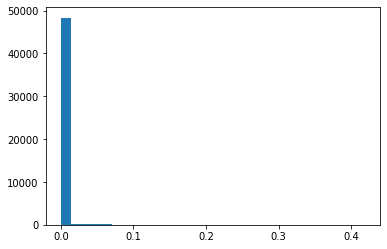

tensor(83.3571, device='cuda:0', grad_fn=<NormBackward1>)


In [27]:
plt.hist(sparse_encoding.cpu().detach().numpy(), bins=30)
plt.show()

l1_regularization = torch.norm(sparse_encoding, 1)
print(l1_regularization)

In [28]:
sparse_encoding.unique(return_counts=True)

(tensor([0.0000e+00, 3.5032e-44, 3.7835e-44,  ..., 3.6315e-01, 3.8732e-01,
         4.1922e-01], device='cuda:0', grad_fn=<Unique2Backward0>),
 tensor([47637,     1,     1,  ...,     1,     1,     1], device='cuda:0'))

In [33]:
(sparse_encoding > 0.1).unique(return_counts=True)

(tensor([False,  True], device='cuda:0'),
 tensor([49120,   288], device='cuda:0'))

In [44]:
test_files[0]

'datasets/flickr30k/test/1007129816.jpg'